In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from scipy import stats

ABCD_PATH = '../../ABCD'
IDENTIFIERS = ['src_subject_id', 'eventname']
EVENTS = ['baseline_year_1_arm_1', '2_year_follow_up_y_arm_1']

FCON_TEMPLATE = 'rsfmri_c_ngd_{0}_ngd_{1}'
FCON = {
    'ad': 'auditory',
    'cgc': 'cingulo-opercular',
    'ca': 'cingulo-parietal',
    'dt': 'default',
    'dla': 'dorsal attention',
    'fo': 'fronto-parietal',
    'n': None,
    'rspltp': 'retrosplenial temporal',
    'smh': 'sensorimotor hand',
    'smm': 'sensorimotor mouth',
    'sa': 'salience',
    'vta': 'ventral attention',
    'vs': 'visual'
}

SCON_TEMPLATE = 'dmri_dtifa_fiberat_{0}'

In [2]:
betnet = pd.read_csv(os.path.join(ABCD_PATH, 'abcd_betnet02.tsv'), sep='\t',
                     skiprows=[1], index_col=IDENTIFIERS)
dti = pd.read_csv(os.path.join(ABCD_PATH, 'abcd_dti_p101.tsv'), sep='\t',
                  skiprows=[1], index_col=IDENTIFIERS)

inclusion = pd.read_csv(os.path.join(ABCD_PATH, 'abcd_imgincl01.tsv'), sep='\t',
                        skiprows=[1], index_col=IDENTIFIERS)
inclusion.dropna(subset=['visit'], inplace=True)
inclusion = inclusion.loc[~inclusion.index.duplicated(keep='last')]

covariates = pd.read_csv('output/abcd_covariates.csv', index_col=IDENTIFIERS)

In [3]:
include = inclusion.loc[(inclusion['imgincl_rsfmri_include'] == 1) &
                        (inclusion['imgincl_dmri_include'] == 1)]
subs_long = [sub for sub, df in include.groupby(level='src_subject_id') if len(df) == 2]

In [4]:
fcon_codes = [n for n, name in FCON.items() if name is not None]
fcon_columns = []
for i in range(len(fcon_codes)):
    for j in range(i+1):
        fcon_columns.append(FCON_TEMPLATE.format(fcon_codes[i], fcon_codes[j]))

fcon = betnet.loc[idx[subs_long, EVENTS], fcon_columns]

In [5]:
scon_column_filter = dti.columns.str.startswith(SCON_TEMPLATE.format(''))

scon = dti.loc[idx[subs_long, EVENTS], scon_column_filter]

# Wendelken-FrontoparietalStructural-2017

In [6]:
fcon_frontoparietal = fcon[FCON_TEMPLATE.format('fo', 'fo')]
scon_frontoparietal = (scon[[SCON_TEMPLATE.format('pslfrh'), SCON_TEMPLATE.format('pslflh')]]
                       .mean(axis=1))

In [7]:
outlier_filter = ((np.abs(stats.zscore(fcon_frontoparietal)) > 3)
                  | (np.abs(stats.zscore(scon_frontoparietal)) > 3))

subs_frontoparietal = [sub for sub, df in fcon_frontoparietal[~outlier_filter]
                       .groupby(level='src_subject_id') if len(df) == 2]
fcon_frontoparietal_noout = fcon_frontoparietal.loc[idx[subs_frontoparietal, EVENTS]]
scon_frontoparietal_noout = scon_frontoparietal.loc[idx[subs_frontoparietal, EVENTS]]

## Demographics

### Age

In [8]:
age_month = covariates.loc[idx[subs_frontoparietal, EVENTS], 'interview_age']
age_month_diff = (age_month.groupby(level='src_subject_id')
                  .diff().dropna().droplevel('eventname'))

data_age = ((age_month / 12).reset_index('eventname')
            .rename(columns={'eventname':'Time Point'})
            .replace({EVENTS[0]:'baseline', EVENTS[1]:'year 2'}))

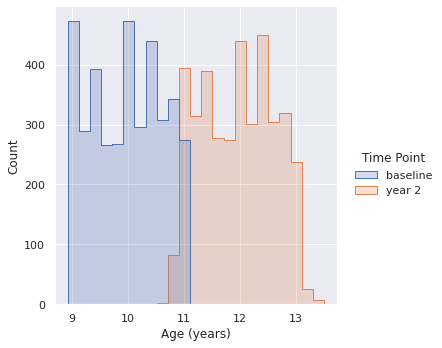

In [9]:
g = sns.displot(data_age, x='interview_age', hue='Time Point', element='step')
g.set_xlabels('Age (years)')

plt.show()

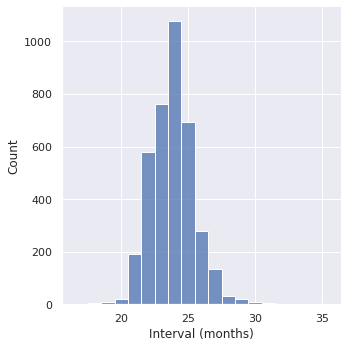

In [10]:
g = sns.displot(age_month_diff, discrete=True)
g.set_xlabels('Interval (months)')

plt.show()

### Sex

In [11]:
sex = covariates.loc[idx[subs_frontoparietal, EVENTS[1]], 'sex']

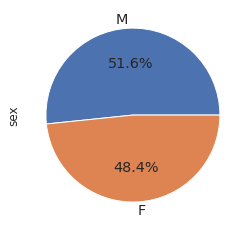

In [12]:
ax = sex.value_counts().plot.pie(autopct='%1.1f%%', textprops={'size':'large'})

plt.show()

### Race

In [13]:
race = covariates.loc[idx[subs_frontoparietal, EVENTS[1]], 'race.6level']

In [14]:
data_race = race.value_counts(dropna=False)
data_race.loc['Other'] = data_race.loc[['Other', 'AIAN/NHPI', np.nan]].sum()
data_race = data_race.drop([np.nan, 'AIAN/NHPI']).rename({'Other':'Other/Unknown'})

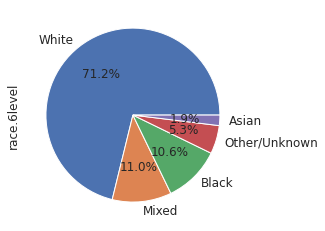

In [15]:
ax = data_race.plot.pie(autopct='%1.1f%%', textprops={'size':'medium'})

plt.show()

## Connectivity

### Development

In [16]:
fcon_frontoparietal_age_linregress = stats.linregress(age_month / 12, fcon_frontoparietal_noout)
scon_frontoparietal_age_linregress = stats.linregress(age_month / 12, scon_frontoparietal_noout)

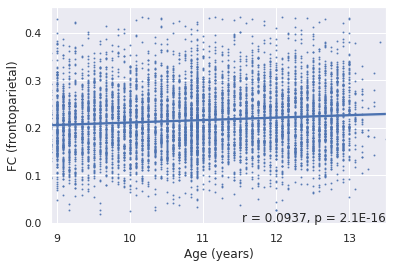

In [17]:
ax = sns.regplot(x=(age_month / 12), y=fcon_frontoparietal_noout, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('FC (frontoparietal)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=fcon_frontoparietal_age_linregress.rvalue,
                                              p=fcon_frontoparietal_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')

plt.show()

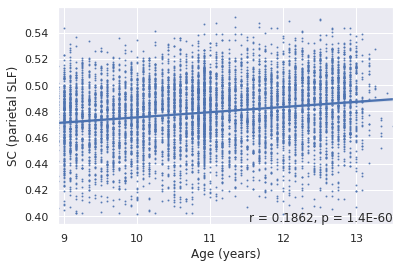

In [18]:
ax = sns.regplot(x=(age_month / 12), y=scon_frontoparietal_noout, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('SC (parietal SLF)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=scon_frontoparietal_age_linregress.rvalue,
                                              p=scon_frontoparietal_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')

plt.show()

In [19]:
fcon_delta_frontoparietal = (fcon_frontoparietal_noout.groupby(level='src_subject_id')
                             .diff().dropna().droplevel('eventname')
                             .divide(age_month_diff / 12).dropna())

In [20]:
scon_delta_frontoparietal = (scon_frontoparietal_noout.groupby(level='src_subject_id')
                             .diff().dropna().droplevel('eventname')
                             .divide(age_month_diff / 12).dropna())

In [21]:
fcon_frontoparietal_ttest = stats.ttest_1samp(fcon_delta_frontoparietal, 0, alternative='greater')
scon_frontoparietal_ttest = stats.ttest_1samp(scon_delta_frontoparietal, 0, alternative='greater')

In [22]:
print('frontoparietal FC change > 0, p = {p:.1E}'.format(p=fcon_frontoparietal_ttest[1]))

frontoparietal FC change > 0, p = 5.5E-22


In [23]:
print('frontoparietal SC change > 0, p = {p:.1E}'.format(p=scon_frontoparietal_ttest[1]))

frontoparietal SC change > 0, p = 1.1E-236


### SC-FC

#### Concurrent

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
data = (pd.DataFrame({'FC': fcon_frontoparietal_noout,
                      'SC': scon_frontoparietal_noout})
        .join(age_month/12).join((age_month_diff/12).rename('age_diff'))
        .join(covariates[['sex', 'site_id', 'rel_family_id']]))

In [26]:
model = smf.mixedlm('FC ~ SC + interview_age', data, groups=data['site_id'])
results = model.fit()
results.summary()

/home/kimsin98/miniconda3/envs/brainhack/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: FC        
No. Observations: 7646    Method:             REML      
No. Groups:       22      Scale:              0.0040    
Min. group size:  8       Log-Likelihood:     10218.7428
Max. group size:  905     Converged:          Yes       
Mean group size:  347.5                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.148    0.016 8.947 0.000  0.115  0.180
SC              0.032    0.034 0.946 0.344 -0.034  0.099
interview_age   0.005    0.001 7.770 0.000  0.004  0.006
Group Var       0.000    0.001                          
========================================================

"""

#### Longitudinal

In [27]:
data_long = (data.xs(EVENTS[0], level='eventname')
             .join(fcon_delta_frontoparietal.rename('dFC'), how='right')
             .join(scon_delta_frontoparietal.rename('dSC')))

In [28]:
def stepwise_selection(X, y, groups, p_enter=0.1, p_remove=0.3, verbose=True):
    """Forward-backward feature selection with MixedLM.
    yoinked from https://datascience.stackexchange.com/a/24447
    
    Parameters:
    - X: pandas.DataFrame with candidate features
    - y: list-like with the target
    - groups: columns of random intercepts
    - p_enter: include if p < p_enter
    - p_remove: exclude if p > p_remove
    - verbose: whether to print the sequence of inclusions and exclusions
    
    Returns:
    - results: final model results
    """
    if p_enter >= p_remove:
        raise ValueError('p_remove must be greater than p_enter to avoid infinite loop')
    
    included = []
    changed = True
    while changed:
        changed = False
        
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.MixedLM(y,
                               sm.add_constant(pd.DataFrame(X[included + [new_column]])),
                               groups)
            new_pval[new_column] = model.fit().pvalues[new_column]
        
        best_pval = new_pval.min()
        if best_pval < p_enter:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:20} with p-value {:.4}'.format(best_feature, best_pval))
        
        # backward step
        model = sm.MixedLM(y,
                           sm.add_constant(pd.DataFrame(X[included])),
                           groups)
        pvalues = model.fit().pvalues.iloc[1:] # all coeffs except intercept
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > p_remove:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:20} with p-value {:.4}'.format(worst_feature, worst_pval))
    
    model = sm.MixedLM(y,
                       sm.add_constant(pd.DataFrame(X[included])),
                       groups)
    return model.fit()

In [29]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter('ignore', ConvergenceWarning)
    results = stepwise_selection(data_long[['FC', 'SC', 'interview_age', 'age_diff', 'dSC']],
                                 data_long['dFC'],
                                 data_long['site_id'],
                                 p_enter=0.2, p_remove=0.4)

results.summary()

Add  FC                   with p-value 0.0
Add  SC                   with p-value 0.1935
Add  interview_age        with p-value 0.1702


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: dFC      
No. Observations:   3823    Method:             REML     
No. Groups:         22      Scale:              0.0009   
Min. group size:    8       Log-Likelihood:     7938.7776
Max. group size:    454     Converged:          Yes      
Mean group size:    173.8                                
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
const          0.081    0.013   6.331 0.000  0.056  0.107
FC            -0.338    0.008 -44.252 0.000 -0.353 -0.323
SC            -0.033    0.023  -1.445 0.148 -0.078  0.012
interview_age  0.001    0.001   1.371 0.170 -0.000  0.003
Group Var      0.000    0.001                            
=========================================================

"""

In [30]:
model = smf.ols('dFC ~ FC + SC + interview_age', data_long)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dFC   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     608.1
Date:                Wed, 07 Apr 2021   Prob (F-statistic):          4.45e-323
Time:                        11:15:33   Log-Likelihood:                 7904.6
No. Observations:                3823   AIC:                        -1.580e+04
Df Residuals:                    3819   BIC:                        -1.578e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0843      0.012      7.042      0.000       0.061       0.108
FC               -0.3290      0.008    -42.643      0.000      -0.344      -0.314
SC               -0.0469      0.020     -2.290      0.022      -0.087      -0.007
interview_age     0.0013      0.001      1.634      0.102      -0.000       0.003
==============================================================================
Omnibus:                       78.811   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.395
Skew:                           0.260   Prob(JB):                     3.53e-23
Kurtosis:                       3.616   Cond. No.                         458.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Generalize